# Calibration

<div class="alert alert-info">
    
An interactive version of this notebook is available on [Google Colab](https://colab.research.google.com/github/starsimhub/starsim/blob/main/docs/tutorials/tut_calibration.ipynb?install=starsim) or [Binder](https://mybinder.org/v2/gh/starsimhub/starsim/HEAD?labpath=docs%2Ftutorials%2Ftut_calibration.ipynb).
    
</div>

Disease models typically require contextualization to a relevant setting of interest prior to addressing "what-if" scenario questions. The process of tuning model input parameters so that model outputs match observed data is known as calibration. There are many approaches to model calibration, ranging from manual tuning to fully Bayesian methods.

For many applications, we have found that an optimization-based approach is sufficient. Such methods avoid the tedious process of manual tuning and are less computationally expensive than fully Bayesian methods. One such optimization-based approach is the Optuna library, which is a Bayesian hyperparameter optimization framework. Optuna is designed for tuning hyperparameters of machine learning models, but it can also be used to calibrate disease models.

Calibration libraries often treat the disease model as a black box, where the input parameters are the "hyperparameters" to be tuned. The calibration process is often iterative and requires a combination of expert knowledge and computational tools. The optimization algorithm iteratively chooses new parameter values to evaluate, and the model is run with these values to generate outputs. The outputs are compared to observed data, and a loss function is calculated to quantify the difference between the model outputs and the observed data. The optimization algorithm then uses this loss function to update its search strategy and choose new parameter values to evaluate. This process continues until the algorithm converges to a set of parameter values that minimize the loss function.

While many optimization algorithms are available, Starsim has a built-in interface to the Optuna library, which we will demonstrate in this tutorial. We will use a simple Susceptible-Infected-Recovered (SIR) model as an example. We will tune three input parameters, the infectivity parameter, `beta`, the initial prevalence parameter, `init_prev`, and the Poisson-distributed degree distribution parameter, `n_contacts`. We will calibrate the model using a beta-binomial likelihood function so as to match prevalence at three distinct time points.

We begin with a few imports and default settings:

In [1]:
#%% Imports and settings
import sciris as sc
import starsim as ss
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

n_agents = 2e3
debug = False # If true, will run in serial

The calibration class will require a base `Sim` object. This `sim` will later be modified according to parameters selected by the optimization engine. The following function creates the base `Sim` object.

In [2]:
def make_sim():
    sir = ss.SIR(
        beta = ss.beta(0.075),
        init_prev = ss.bernoulli(0.02),
    )
    random = ss.RandomNet(n_contacts=ss.poisson(4))

    sim = ss.Sim(
        n_agents = n_agents,
        start = sc.date('2020-01-01'),
        stop = sc.date('2020-02-12'),
        dt = 1,
        unit = 'day',
        diseases = sir,
        networks = random,
        verbose = 0,
    )

    return sim

Now let's define the calibration parameters. These are the inputs that Optuna will be able to modify. Here, we define three such parameters, `beta`, `init_prev`, and `n_contacts`.

Each parameter entry should have range defined by `low` and `high` as well as a `guess` values. The `guess` value is not used by Optuna, rather only for a check after calibration completes to see if the new parameters are better than the `guess` values.

You'll notice there are a few other parameters that can be specified. For example, the data type of the parameter appears in `suggest_type`. Possible values are listed in the Optuna documentation, and include [suggest_float](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_float) for float values and [suggest_int](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_int) for integer types.

To make things easier for the search algorithm, it's helpful to indicate how outputs are expected to change with inputs. For example, increasing `beta` from 0.01 to 0.02 should double disease transmission, but increasing from 0.11 to 0.12 will have a small effect. Thus, we indicate that this parameter should be calibrated with `log=True`.

In [3]:
# Define the calibration parameters
calib_pars = dict(
    beta = dict(low=0.01, high=0.30, guess=0.15, suggest_type='suggest_float', log=True), # Note the log scale
    init_prev = dict(low=0.01, high=0.05, guess=0.15), # Default type is suggest_float, no need to re-specify
    n_contacts = dict(low=2, high=10, guess=3, suggest_type='suggest_int'), # Suggest int just for this demo
)

The optimization engine iteratively chooses input parameters to simulate. Those parameters are passed into the following `build_sim` function as a dictionary of `calib_pars` along with the base `sim` and any other key word arguments. The `calib_pars` will be as above, but importantly will have an additional key named `value` containing the value selected by Optuna.

When modifying a `sim`, it is important to realize that the simulation has not been initialized yet. Nonetheless, the configuration is available for modification at `sim.pars`, as demonstrated in the function below for the SIR example.

In [4]:
def build_sim(sim, calib_pars, n_reps=1, **kwargs):
    """
    Modify the base simulation by applying calib_pars. The result can be a
    single simulation or multiple simulations if n_reps>1. Note that here we are
    simply building the simulation by modifying the base sim. Running the sims
    and extracting results will be done by the calibration function.
    """

    sir = sim.pars.diseases # There is only one disease in this simulation and it is a SIR
    net = sim.pars.networks # There is only one network in this simulation and it is a RandomNet

    for k, pars in calib_pars.items(): # Loop over the calibration parameters
        if k == 'rand_seed':
            sim.pars.rand_seed = v
            continue

        # Each item in calib_pars is a dictionary with keys like 'low', 'high',
        # 'guess', 'suggest_type', and importantly 'value'. The 'value' key is
        # the one we want to use as that's the one selected by the algorithm
        v = pars['value']
        if k == 'beta':
            sir.pars.beta = ss.beta(v)
        elif k == 'init_prev':
            sir.pars.init_prev = ss.bernoulli(v)
        elif k == 'n_contacts':
            net.pars.n_contacts = ss.poisson(v)
        else:
            raise NotImplementedError(f'Parameter {k} not recognized')

    # If just one simulation per parameter set, return the single simulation
    if n_reps == 1:
        return sim

    # But if you'd like to run multiple simulations with the same parameters, we return a MultiSim instead
    # Note that each simulation will have a different random seed, you can set specific seeds if you like
    # Also note that parallel=False and debug=True are important to avoid issues with parallelism in the calibration
    # Advanced: If running multiple reps, you can choose if/how they are combined using the "combine_reps" argument to each CalibComponent, introduced below.
    ms = ss.MultiSim(sim, iterpars=dict(rand_seed=np.random.randint(0, 1e6, n_reps)), initialize=True, debug=True, parallel=False)
    return ms

The Starsim framework has been integrated with the Optuna hyperparameter optimization algorithm to facilitate calibration through the `Calibration` class. Recall that an optimization-based approach to calibration minimizes a function of the input parameters. This function is key to achieving an acceptable calibration.

There are two ways to describe the goodness-of-fit function for the `Calibration`. The first method is to directly provide a function that the algorithm will call. The `eval_fn` will be passed each completed `sim` after running, and is expected to return a float representing the **mismatch (lower is better as the optimization algorithm is configured to minimize)**. Data can be passed into the `eval_fn` via `eval_kwargs`.

As an alternative to directly specifying the evaluation function, you can use `CalibComponent`s. Each component includes real data, for example from a survey, that is compared against simulation data from the model. Several components and be used at the same time, for example one for disease prevalence and another for treatment coverage. Each component computes a likelihood of the data given the input parameters, as assessed via simulation. Components are combined assuming independence.

The base class for a component is called `CalibComponent`, which you can use to define your own likelihood. However, we have provided components for several key likelihood functions including `BetaBinomial`, `Binomial`, `DirichletMultinomial`, `GammaPoisson`, and `Normal`. The `Normal` component is most like a traditional squared error. Each component takes in a `name` and a `weight`, which is used when combining log likelihoods.

Importantly, each component takes in the calibration target, the real data that was observed, in an argument called `expected`. This argument should be a Pandas Dataframe with one row per time point and columns that will depend on the specific component type. For example, the `Binomial` component requires columns of `n` (trials) and `x` (successes).

The components also handle extracting data from each simulation using the `extract_fn` argument. The value of this argument should be a function that takes in a simulation and returns a Pandas DataFrame. The specifics of the columns will depend a bit on the type of component (e.g. `BetaBinomial` is different from `Normal`), but often looks like a simulated version of `expected`. We will see examples below.

We'll also see how to use the `conform` argument, the purpose of which is to temporally align the simulation output to the real data. This argument works along with the `extract_fn` to produce the final simulation outputs that are used in the likelihood function. The conformer is a function that takes in the `expected` data you provided and the `actual` simulation result the comes out of the `extract_fn`. The conformers we have built in are as follows:
* `step_containing`: Conform by simply choosing the simulated timestep that contains the time indicated in the real data (`expected`)
* `prevalent`: Interpolate the simulated timepoints to estimate the values that would have occurred at each real timepoint
* `incident`: While the two methods above capture the state of the model at a particular point in time (stocks), this component allows you to capture the behavior of the model over time (flows). Instead of just giving one time value, `t`, you'll provide a second time value as well called `t1`. This conformer will add up events occurring between the two time points.

Let's make a Binomial component, as might be used to calibrate disease prevalence.

In [5]:
prevalence = ss.Normal(
    name = 'Disease prevalence',
    conform = 'prevalent',

    expected = pd.DataFrame({
        'x': [0.13, 0.16, 0.06],    # Prevalence of infection
    }, index=pd.Index([ss.date(d) for d in ['2020-01-12', '2020-01-25', '2020-02-02']], name='t')), # On these dates
    
    extract_fn = lambda sim: pd.DataFrame({
        'x': sim.results.sir.prevalence,
    }, index=pd.Index(sim.results.timevec, name='t')),

    # You can specify the variance as well, but it's optional (max likelihood estimates will be used if not provided)
    # This could be a single float or an array with the same shape as the expected values
    sigma2 = 0.05, # e.g. (num_replicates/sigma2_model + 1/sigma2_data)^-1
    #sigma2 = np.array([0.05, 0.25, 0.01])
)

Finally, we can bring all the pieces together. We make a single base simulation and create an instance of a Starsim Calibration object. This object requires a few arguments, like the `calib_pars` and `sim`. We also pass in the function that modifies the base `sim`, here our `build_sim` function. No additional `build_kw` are required in this example.

We also pass in a list of `components`. Instead of using this "component-based" system, a user could simply provide an `eval_fn`, which takes in a completed sim an any `eval_kwargs` and returns a "mismatch" score to be minimized.

We can also specify the total number of trials to run, the number of parallel works, and a few other parameters.

In [6]:
sc.heading('Beginning calibration')

# Make the sim and data
sim = make_sim()

# Make the calibration
calib = ss.Calibration(
    calib_pars = calib_pars,
    sim = sim,
    build_fn = build_sim,
    build_kw = dict(n_reps=3), # Run 3 replicates for each parameter set
    reseed = True, # If true, a different random seed will be provided to each configuration
    components = [prevalence],
    total_trials = 100,
    n_workers = None, # None indicates to use all available CPUs
    die = True,
    debug = debug, # Run in serial if True
)

# Perform the calibration
sc.printcyan('\nPeforming calibration...')
calib.calibrate();



—————————————————————
Beginning calibration
—————————————————————


Peforming calibration...
Removed existing calibration file starsim_calibration.db
sqlite:///starsim_calibration.db


[I 2025-03-06 03:10:03,796] A new study created in RDB with name: starsim_calibration


Elapsed time: 0.529 s

[I 2025-03-06 03:10:04,928] Trial 1 finished with value: -0.5223463224837276 and parameters: {'beta': 0.06796212487938758, 'init_prev': 0.03470098201798985, 'n_contacts': 3, 'rand_seed': 913718}. Best is trial 1 with value: -0.5223463224837276.


Elapsed time: 0.580 s

Elapsed time: 0.545 s

[I 2025-03-06 03:10:05,070] Trial 0 finished with value: -0.3169344473876654 and parameters: {'beta': 0.16309654487374242, 'init_prev': 0.028656151727261187, 'n_contacts': 7, 'rand_seed': 836658}. Best is trial 1 with value: -0.5223463224837276.


Elapsed time: 0.519 s

[I 2025-03-06 03:10:05,087] Trial 8 finished with value: -0.48169897900946257 and parameters: {'beta': 0.08756235454180157, 'init_prev': 0.03752379784875525, 'n_contacts': 2, 'rand_seed': 725203}. Best is trial 1 with value: -0.5223463224837276.


Elapsed time: 0.501 s

[I 2025-03-06 03:10:05,150] Trial 12 finished with value: -0.42895047819290016 and parameters: {'beta': 0.02512586516430473, 'init_prev': 0.04432969300149127, 'n_contacts': 2, 'rand_seed': 142185}. Best is trial 1 with value: -0.5223463224837276.


Elapsed time: 0.716 s

[I 2025-03-06 03:10:05,153] Trial 11 finished with value: -0.44146911086018364 and parameters: {'beta': 0.024859890567969705, 'init_prev': 0.04687378899442702, 'n_contacts': 4, 'rand_seed': 96219}. Best is trial 1 with value: -0.5223463224837276.


[I 2025-03-06 03:10:05,259] Trial 3 finished with value: 0.24259661039792085 and parameters: {'beta': 0.12585454751961436, 'init_prev': 0.021345518909217903, 'n_contacts': 7, 'rand_seed': 993328}. Best is trial 1 with value: -0.5223463224837276.


Elapsed time: 0.469 s

Elapsed time: 0.616 s

[I 2025-03-06 03:10:05,361] Trial 5 finished with value: -0.42711831482982654 and parameters: {'beta': 0.014766017387822525, 'init_prev': 0.025595175803772605, 'n_contacts': 3, 'rand_seed': 529575}. Best is trial 1 with value: -0.5223463224837276.


Elapsed time: 0.507 s

Elapsed time: 0.524 s

Elapsed time: 0.713 s

Elapsed time: 0.795 s

[I 2025-03-06 03:10:05,405] Trial 13 finished with value: -0.5273105453713264 and parameters: {'beta': 0.059942142023924734, 'init_prev': 0.010805631674619716, 'n_contacts': 6, 'rand_seed': 669981}. Best is trial 13 with value: -0.5273105453713264.


Elapsed time: 0.720 s

Elapsed time: 0.680 s

Elapsed time: 0.614 s

[I 2025-03-06 03:10:05,453] Trial 9 finished with value: -0.14446994360162568 and parameters: {'beta': 0.12936986591104419, 'init_prev': 0.026240608971208126, 'n_contacts': 8, 'rand_seed': 214464}. Best is trial 13 with value: -0.5273105453713264.


[I 2025-03-06 03:10:05,454] Trial 18 finished with value: -0.47873585860538526 and parameters: {'beta': 0.22571616503101907, 'init_prev': 0.04179333841246102, 'n_contacts': 6, 'rand_seed': 46864}. Best is trial 13 with value: -0.5273105453713264.


Elapsed time: 0.497 s

Elapsed time: 0.465 s

[I 2025-03-06 03:10:05,488] Trial 16 finished with value: -0.4337083317994087 and parameters: {'beta': 0.015858942251666012, 'init_prev': 0.04989197804790284, 'n_contacts': 5, 'rand_seed': 443150}. Best is trial 13 with value: -0.5273105453713264.


Elapsed time: 0.767 s

[I 2025-03-06 03:10:05,490] Trial 14 finished with value: -0.43641876444453753 and parameters: {'beta': 0.2500484140838804, 'init_prev': 0.044875941510672854, 'n_contacts': 10, 'rand_seed': 214720}. Best is trial 19 with value: -0.5291085434741903.


[I 2025-03-06 03:10:05,490] Trial 4 finished with value: -0.4770694498763873 and parameters: {'beta': 0.09398169476961335, 'init_prev': 0.017553656954395827, 'n_contacts': 2, 'rand_seed': 190559}. Best is trial 13 with value: -0.5273105453713264.


[I 2025-03-06 03:10:05,491] Trial 7 finished with value: -0.4282904391716637 and parameters: {'beta': 0.012059520730192884, 'init_prev': 0.017716924306675937, 'n_contacts': 8, 'rand_seed': 410060}. Best is trial 19 with value: -0.5291085434741903.


Elapsed time: 0.704 s

Elapsed time: 0.692 s

[I 2025-03-06 03:10:05,498] Trial 19 finished with value: -0.5291085434741903 and parameters: {'beta': 0.11755989481913016, 'init_prev': 0.016051294953676364, 'n_contacts': 2, 'rand_seed': 41962}. Best is trial 19 with value: -0.5291085434741903.


[I 2025-03-06 03:10:05,562] Trial 6 finished with value: -0.5270337413740436 and parameters: {'beta': 0.03585997144991572, 'init_prev': 0.03349055050754887, 'n_contacts': 9, 'rand_seed': 888296}. Best is trial 19 with value: -0.5291085434741903.


[I 2025-03-06 03:10:05,570] Trial 10 finished with value: -0.4344526597993848 and parameters: {'beta': 0.012420194728058737, 'init_prev': 0.04541113198772488, 'n_contacts': 6, 'rand_seed': 699639}. Best is trial 19 with value: -0.5291085434741903.


[I 2025-03-06 03:10:05,612] Trial 2 finished with value: -0.5566991100959046 and parameters: {'beta': 0.08616375649142154, 'init_prev': 0.018644662889703983, 'n_contacts': 3, 'rand_seed': 588798}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.487 s

Elapsed time: 0.551 s

[I 2025-03-06 03:10:05,707] Trial 15 finished with value: -0.46474626505046285 and parameters: {'beta': 0.08185466145477233, 'init_prev': 0.024889673705732786, 'n_contacts': 2, 'rand_seed': 897352}. Best is trial 2 with value: -0.5566991100959046.


[I 2025-03-06 03:10:05,709] Trial 20 finished with value: -0.43101520003809135 and parameters: {'beta': 0.02980059957421394, 'init_prev': 0.048054022025105864, 'n_contacts': 2, 'rand_seed': 11846}. Best is trial 2 with value: -0.5566991100959046.


[I 2025-03-06 03:10:05,715] Trial 21 finished with value: -0.42881065912787825 and parameters: {'beta': 0.011761751496387186, 'init_prev': 0.02862798527134843, 'n_contacts': 5, 'rand_seed': 862315}. Best is trial 2 with value: -0.5566991100959046.


[I 2025-03-06 03:10:05,725] Trial 17 finished with value: 0.09018415655575263 and parameters: {'beta': 0.09383151989899809, 'init_prev': 0.03897118363392441, 'n_contacts': 6, 'rand_seed': 734696}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.494 s

Elapsed time: 0.419 s

[I 2025-03-06 03:10:05,806] Trial 22 finished with value: -0.4644907787565738 and parameters: {'beta': 0.22207676742765917, 'init_prev': 0.022517753510075993, 'n_contacts': 10, 'rand_seed': 28812}. Best is trial 2 with value: -0.5566991100959046.


[I 2025-03-06 03:10:05,807] Trial 23 finished with value: 0.12903737347259006 and parameters: {'beta': 0.0924424377246471, 'init_prev': 0.016890252743295787, 'n_contacts': 10, 'rand_seed': 440214}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.390 s

Elapsed time: 0.670 s

Elapsed time: 0.565 s

[I 2025-03-06 03:10:05,980] Trial 26 finished with value: -0.41323136013442785 and parameters: {'beta': 0.1724954899817156, 'init_prev': 0.026428987232016914, 'n_contacts': 7, 'rand_seed': 322258}. Best is trial 2 with value: -0.5566991100959046.


[I 2025-03-06 03:10:06,030] Trial 25 finished with value: -0.427686433293982 and parameters: {'beta': 0.024771284413309485, 'init_prev': 0.016844428243053364, 'n_contacts': 3, 'rand_seed': 527832}. Best is trial 2 with value: -0.5566991100959046.


[I 2025-03-06 03:10:06,097] Trial 24 finished with value: -0.29167326272958605 and parameters: {'beta': 0.06483605746441931, 'init_prev': 0.018384963679686, 'n_contacts': 7, 'rand_seed': 534052}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.406 s

[I 2025-03-06 03:10:06,143] Trial 35 finished with value: -0.44425145951766315 and parameters: {'beta': 0.03862491054149701, 'init_prev': 0.010598790939086753, 'n_contacts': 4, 'rand_seed': 322394}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.666 s

Elapsed time: 0.503 s

Elapsed time: 0.415 s

[I 2025-03-06 03:10:06,279] Trial 27 finished with value: 0.33299738395099254 and parameters: {'beta': 0.061687668724734676, 'init_prev': 0.010466862109399663, 'n_contacts': 10, 'rand_seed': 701672}. Best is trial 2 with value: -0.5566991100959046.


[I 2025-03-06 03:10:06,289] Trial 34 finished with value: -0.4566600601382054 and parameters: {'beta': 0.042794113891873944, 'init_prev': 0.011251039902846954, 'n_contacts': 4, 'rand_seed': 312965}. Best is trial 2 with value: -0.5566991100959046.


[I 2025-03-06 03:10:06,297] Trial 30 finished with value: -0.5531543498961731 and parameters: {'beta': 0.05270103748791377, 'init_prev': 0.014569246818444152, 'n_contacts': 5, 'rand_seed': 694753}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.667 s

Elapsed time: 0.529 s

[I 2025-03-06 03:10:06,338] Trial 31 finished with value: -0.5319042976556632 and parameters: {'beta': 0.04716268064864504, 'init_prev': 0.012067517833191951, 'n_contacts': 5, 'rand_seed': 605349}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.609 s

Elapsed time: 0.706 s

Elapsed time: 0.707 s

Elapsed time: 0.581 s

Elapsed time: 0.534 s

Elapsed time: 0.486 s

[I 2025-03-06 03:10:06,430] Trial 33 finished with value: -0.5406144435007625 and parameters: {'beta': 0.048452621537661174, 'init_prev': 0.012030512323683013, 'n_contacts': 5, 'rand_seed': 638425}. Best is trial 2 with value: -0.5566991100959046.


[I 2025-03-06 03:10:06,434] Trial 32 finished with value: -0.5216741001697918 and parameters: {'beta': 0.04832870403212027, 'init_prev': 0.010908735174676214, 'n_contacts': 5, 'rand_seed': 645382}. Best is trial 2 with value: -0.5566991100959046.


[I 2025-03-06 03:10:06,435] Trial 36 finished with value: -0.4652566051030541 and parameters: {'beta': 0.046858628249043376, 'init_prev': 0.011020997279599543, 'n_contacts': 4, 'rand_seed': 330493}. Best is trial 2 with value: -0.5566991100959046.


[I 2025-03-06 03:10:06,446] Trial 37 finished with value: -0.4913210102145888 and parameters: {'beta': 0.04901255057363161, 'init_prev': 0.011844768604503252, 'n_contacts': 4, 'rand_seed': 595682}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.443 s

[I 2025-03-06 03:10:06,451] Trial 40 finished with value: -0.4841237785349237 and parameters: {'beta': 0.05138222830609046, 'init_prev': 0.012767382072267118, 'n_contacts': 4, 'rand_seed': 578327}. Best is trial 2 with value: -0.5566991100959046.


[I 2025-03-06 03:10:06,452] Trial 38 finished with value: -0.44999989803099955 and parameters: {'beta': 0.04899898328757991, 'init_prev': 0.011251199272529865, 'n_contacts': 4, 'rand_seed': 567666}. Best is trial 2 with value: -0.5566991100959046.


[I 2025-03-06 03:10:06,459] Trial 41 finished with value: -0.46271933094154843 and parameters: {'beta': 0.04561925185525177, 'init_prev': 0.010826071791253415, 'n_contacts': 4, 'rand_seed': 588140}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.743 s

Elapsed time: 0.537 s

[I 2025-03-06 03:10:06,540] Trial 28 finished with value: -0.041468424347317644 and parameters: {'beta': 0.05216001053343612, 'init_prev': 0.011049092986289333, 'n_contacts': 10, 'rand_seed': 597365}. Best is trial 2 with value: -0.5566991100959046.


[I 2025-03-06 03:10:06,581] Trial 43 finished with value: -0.4774114915591757 and parameters: {'beta': 0.05023366018545442, 'init_prev': 0.010687279922898132, 'n_contacts': 4, 'rand_seed': 573798}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.685 s

Elapsed time: 0.525 s

[I 2025-03-06 03:10:06,676] Trial 39 finished with value: -0.47767537340665306 and parameters: {'beta': 0.04793809739580185, 'init_prev': 0.010285222550060508, 'n_contacts': 4, 'rand_seed': 589244}. Best is trial 2 with value: -0.5566991100959046.


[I 2025-03-06 03:10:06,678] Trial 29 finished with value: -0.2680290106010294 and parameters: {'beta': 0.04812331645864619, 'init_prev': 0.01023208803120062, 'n_contacts': 10, 'rand_seed': 629221}. Best is trial 2 with value: -0.5566991100959046.


[I 2025-03-06 03:10:06,678] Trial 42 finished with value: -0.49649732591552886 and parameters: {'beta': 0.051523839246608034, 'init_prev': 0.010054150842210573, 'n_contacts': 4, 'rand_seed': 598235}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.528 s

Elapsed time: 0.413 s

[I 2025-03-06 03:10:06,741] Trial 45 finished with value: -0.4762986981852653 and parameters: {'beta': 0.050076276153216505, 'init_prev': 0.010672663143906178, 'n_contacts': 4, 'rand_seed': 618552}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.649 s

[I 2025-03-06 03:10:06,823] Trial 47 finished with value: -0.49476876893113864 and parameters: {'beta': 0.05152533704278764, 'init_prev': 0.010072060129482883, 'n_contacts': 4, 'rand_seed': 595312}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.445 s

[I 2025-03-06 03:10:06,866] Trial 44 finished with value: -0.4653691474751373 and parameters: {'beta': 0.051888386407452906, 'init_prev': 0.011169705589748728, 'n_contacts': 4, 'rand_seed': 608794}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.440 s

[I 2025-03-06 03:10:06,932] Trial 49 finished with value: 0.5113715664244911 and parameters: {'beta': 0.13759304473356013, 'init_prev': 0.012903925744708104, 'n_contacts': 5, 'rand_seed': 608522}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.675 s

[I 2025-03-06 03:10:07,013] Trial 46 finished with value: -0.46331345131258517 and parameters: {'beta': 0.04868432446366066, 'init_prev': 0.010476960457688164, 'n_contacts': 4, 'rand_seed': 640880}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.441 s

[I 2025-03-06 03:10:07,062] Trial 55 finished with value: -0.5387392532985822 and parameters: {'beta': 0.07770260664612341, 'init_prev': 0.01399098149870228, 'n_contacts': 3, 'rand_seed': 824742}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.478 s

[I 2025-03-06 03:10:07,138] Trial 48 finished with value: -0.5565271614704128 and parameters: {'beta': 0.05469314548197668, 'init_prev': 0.013969943423973596, 'n_contacts': 5, 'rand_seed': 642540}. Best is trial 2 with value: -0.5566991100959046.


[I 2025-03-06 03:10:07,140] Trial 54 finished with value: -0.522105748957686 and parameters: {'beta': 0.07228537986775897, 'init_prev': 0.014486439573696568, 'n_contacts': 3, 'rand_seed': 803938}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.637 s

Elapsed time: 0.623 s

Elapsed time: 0.461 s

[I 2025-03-06 03:10:07,202] Trial 50 finished with value: -0.5403319790297343 and parameters: {'beta': 0.07311512066565344, 'init_prev': 0.014037672568360447, 'n_contacts': 5, 'rand_seed': 784043}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.525 s

Elapsed time: 0.616 s

Elapsed time: 0.494 s

[I 2025-03-06 03:10:07,282] Trial 57 finished with value: -0.48332287276382224 and parameters: {'beta': 0.1341259632523208, 'init_prev': 0.014223172782175898, 'n_contacts': 3, 'rand_seed': 809979}. Best is trial 2 with value: -0.5566991100959046.


Elapsed time: 0.691 s

[I 2025-03-06 03:10:07,295] Trial 52 finished with value: -0.526642385619483 and parameters: {'beta': 0.07298420227027434, 'init_prev': 0.013921418537650655, 'n_contacts': 3, 'rand_seed': 797675}. Best is trial 2 with value: -0.5566991100959046.


[I 2025-03-06 03:10:07,299] Trial 60 finished with value: -0.566143225864153 and parameters: {'beta': 0.11613530493254796, 'init_prev': 0.015000356602931546, 'n_contacts': 3, 'rand_seed': 810299}. Best is trial 60 with value: -0.566143225864153.


[I 2025-03-06 03:10:07,318] Trial 53 finished with value: -0.5234299763985001 and parameters: {'beta': 0.07251941765388181, 'init_prev': 0.014801418729445143, 'n_contacts': 3, 'rand_seed': 783879}. Best is trial 60 with value: -0.566143225864153.


[I 2025-03-06 03:10:07,340] Trial 51 finished with value: -0.4339665116055923 and parameters: {'beta': 0.032438436277751594, 'init_prev': 0.01430352849042902, 'n_contacts': 3, 'rand_seed': 794874}. Best is trial 2 with value: -0.5566991100959046.


[I 2025-03-06 03:10:07,370] Trial 56 finished with value: -0.5299036844909202 and parameters: {'beta': 0.07655181941837612, 'init_prev': 0.014691443737601348, 'n_contacts': 3, 'rand_seed': 788162}. Best is trial 60 with value: -0.566143225864153.


Elapsed time: 0.508 s

Elapsed time: 0.572 s

Elapsed time: 0.695 s

[I 2025-03-06 03:10:07,464] Trial 62 finished with value: -0.5479748088682057 and parameters: {'beta': 0.11694723882173166, 'init_prev': 0.014226889701468723, 'n_contacts': 3, 'rand_seed': 789574}. Best is trial 58 with value: -0.5682165626333551.


Elapsed time: 0.525 s

[I 2025-03-06 03:10:07,471] Trial 58 finished with value: -0.5682165626333551 and parameters: {'beta': 0.11107472730355616, 'init_prev': 0.013999751652901848, 'n_contacts': 3, 'rand_seed': 792812}. Best is trial 58 with value: -0.5682165626333551.


Elapsed time: 0.676 s

[I 2025-03-06 03:10:07,487] Trial 61 finished with value: -0.5259094719419872 and parameters: {'beta': 0.0731179759706661, 'init_prev': 0.014648410942455205, 'n_contacts': 3, 'rand_seed': 794309}. Best is trial 58 with value: -0.5682165626333551.


Elapsed time: 0.417 s

Elapsed time: 0.594 s

[I 2025-03-06 03:10:07,521] Trial 64 finished with value: -0.5423223675547681 and parameters: {'beta': 0.11922671153078356, 'init_prev': 0.014671031771309583, 'n_contacts': 3, 'rand_seed': 779878}. Best is trial 58 with value: -0.5682165626333551.


[I 2025-03-06 03:10:07,523] Trial 59 finished with value: -0.5407601760581007 and parameters: {'beta': 0.11710486952536649, 'init_prev': 0.014429216072763484, 'n_contacts': 3, 'rand_seed': 753532}. Best is trial 58 with value: -0.5682165626333551.


Elapsed time: 0.408 s

[I 2025-03-06 03:10:07,579] Trial 63 finished with value: -0.5498779048426193 and parameters: {'beta': 0.11822941791626874, 'init_prev': 0.013958652730515556, 'n_contacts': 3, 'rand_seed': 776919}. Best is trial 58 with value: -0.5682165626333551.


[I 2025-03-06 03:10:07,579] Trial 67 finished with value: -0.49794220648582743 and parameters: {'beta': 0.0710419956709418, 'init_prev': 0.01414018672731149, 'n_contacts': 3, 'rand_seed': 777254}. Best is trial 58 with value: -0.5682165626333551.


Elapsed time: 0.570 s

Elapsed time: 0.430 s

Elapsed time: 0.650 s

[I 2025-03-06 03:10:07,681] Trial 65 finished with value: -0.5241755762906567 and parameters: {'beta': 0.07689062911975965, 'init_prev': 0.014436674221309282, 'n_contacts': 3, 'rand_seed': 753733}. Best is trial 58 with value: -0.5682165626333551.


[I 2025-03-06 03:10:07,692] Trial 69 finished with value: -0.5270822498159662 and parameters: {'beta': 0.07197692181334953, 'init_prev': 0.013849641141198878, 'n_contacts': 3, 'rand_seed': 791394}. Best is trial 58 with value: -0.5682165626333551.


Elapsed time: 0.417 s

[I 2025-03-06 03:10:07,711] Trial 66 finished with value: -0.5237867524157931 and parameters: {'beta': 0.07532264732626236, 'init_prev': 0.014639877178265797, 'n_contacts': 3, 'rand_seed': 786673}. Best is trial 58 with value: -0.5682165626333551.


[I 2025-03-06 03:10:07,774] Trial 70 finished with value: -0.5380425496749304 and parameters: {'beta': 0.07461690851493027, 'init_prev': 0.019637250040352747, 'n_contacts': 3, 'rand_seed': 795024}. Best is trial 58 with value: -0.5682165626333551.


[I 2025-03-06 03:10:07,775] Trial 68 finished with value: -0.5322624837104802 and parameters: {'beta': 0.0751371720538229, 'init_prev': 0.01434068135683157, 'n_contacts': 3, 'rand_seed': 776113}. Best is trial 58 with value: -0.5682165626333551.


Elapsed time: 0.591 s

Elapsed time: 0.565 s

[I 2025-03-06 03:10:07,944] Trial 71 finished with value: -0.5308293367211112 and parameters: {'beta': 0.07594577081478666, 'init_prev': 0.0195719823551117, 'n_contacts': 3, 'rand_seed': 765322}. Best is trial 58 with value: -0.5682165626333551.


[I 2025-03-06 03:10:07,989] Trial 72 finished with value: 0.061340866610066574 and parameters: {'beta': 0.10591389274941698, 'init_prev': 0.019671434448102498, 'n_contacts': 5, 'rand_seed': 939442}. Best is trial 58 with value: -0.5682165626333551.


Elapsed time: 0.464 s

[I 2025-03-06 03:10:08,101] Trial 75 finished with value: 0.29872566011770973 and parameters: {'beta': 0.10869608925841384, 'init_prev': 0.020758158864046063, 'n_contacts': 6, 'rand_seed': 732242}. Best is trial 58 with value: -0.5682165626333551.


Elapsed time: 0.470 s

Elapsed time: 0.560 s

Elapsed time: 0.625 s

Elapsed time: 0.618 s

Elapsed time: 0.707 s

[I 2025-03-06 03:10:08,159] Trial 78 finished with value: -0.5401079876678375 and parameters: {'beta': 0.11787212966201782, 'init_prev': 0.01932528696833475, 'n_contacts': 2, 'rand_seed': 736799}. Best is trial 58 with value: -0.5682165626333551.


[I 2025-03-06 03:10:08,179] Trial 80 finished with value: -0.5003675329185199 and parameters: {'beta': 0.1046532555046579, 'init_prev': 0.018609134832130492, 'n_contacts': 2, 'rand_seed': 941386}. Best is trial 58 with value: -0.5682165626333551.


[I 2025-03-06 03:10:08,205] Trial 77 finished with value: 0.283660517983366 and parameters: {'beta': 0.10731976983084741, 'init_prev': 0.019874192590603613, 'n_contacts': 6, 'rand_seed': 748444}. Best is trial 58 with value: -0.5682165626333551.


[I 2025-03-06 03:10:08,206] Trial 74 finished with value: 0.24631653797486042 and parameters: {'beta': 0.11403760099453984, 'init_prev': 0.020039242930867673, 'n_contacts': 6, 'rand_seed': 956667}. Best is trial 58 with value: -0.5682165626333551.


Elapsed time: 0.729 s

Elapsed time: 0.516 s

Elapsed time: 0.500 s

[I 2025-03-06 03:10:08,222] Trial 73 finished with value: 0.004769100452114687 and parameters: {'beta': 0.08460355099909436, 'init_prev': 0.02121692444733209, 'n_contacts': 6, 'rand_seed': 975825}. Best is trial 58 with value: -0.5682165626333551.


Elapsed time: 0.509 s

[I 2025-03-06 03:10:08,248] Trial 76 finished with value: 0.30539192016602046 and parameters: {'beta': 0.10372719847404273, 'init_prev': 0.019474272631167695, 'n_contacts': 6, 'rand_seed': 747128}. Best is trial 84 with value: -0.5690193139033011.


[I 2025-03-06 03:10:08,258] Trial 84 finished with value: -0.5690193139033011 and parameters: {'beta': 0.15177622687707137, 'init_prev': 0.019167888601555425, 'n_contacts': 2, 'rand_seed': 937387}. Best is trial 84 with value: -0.5690193139033011.


Elapsed time: 0.676 s

[I 2025-03-06 03:10:08,292] Trial 82 finished with value: -0.5101727606783234 and parameters: {'beta': 0.10208292683385409, 'init_prev': 0.019322603897799457, 'n_contacts': 2, 'rand_seed': 959720}. Best is trial 84 with value: -0.5690193139033011.


Elapsed time: 0.469 s

Elapsed time: 0.557 s

[I 2025-03-06 03:10:08,347] Trial 79 finished with value: -0.5132106321725374 and parameters: {'beta': 0.1055526977093072, 'init_prev': 0.019045763789756823, 'n_contacts': 2, 'rand_seed': 954538}. Best is trial 84 with value: -0.5690193139033011.


[I 2025-03-06 03:10:08,366] Trial 86 finished with value: -0.5250765670642733 and parameters: {'beta': 0.10332695771497118, 'init_prev': 0.019068826306135406, 'n_contacts': 2, 'rand_seed': 968253}. Best is trial 84 with value: -0.5690193139033011.


[I 2025-03-06 03:10:08,368] Trial 83 finished with value: -0.5648225487876714 and parameters: {'beta': 0.16554753541096787, 'init_prev': 0.019179740748892848, 'n_contacts': 2, 'rand_seed': 917719}. Best is trial 84 with value: -0.5690193139033011.


[I 2025-03-06 03:10:08,372] Trial 81 finished with value: -0.5080484668904338 and parameters: {'beta': 0.10367601045195189, 'init_prev': 0.018708816844863835, 'n_contacts': 2, 'rand_seed': 947288}. Best is trial 84 with value: -0.5690193139033011.


Elapsed time: 0.461 s

[I 2025-03-06 03:10:08,414] Trial 88 finished with value: -0.5167968194259769 and parameters: {'beta': 0.1099851275268809, 'init_prev': 0.019182174194923615, 'n_contacts': 2, 'rand_seed': 938632}. Best is trial 84 with value: -0.5690193139033011.


Elapsed time: 0.439 s

[I 2025-03-06 03:10:08,452] Trial 90 finished with value: -0.49280315518896156 and parameters: {'beta': 0.10171983961890994, 'init_prev': 0.02005900503992282, 'n_contacts': 2, 'rand_seed': 858295}. Best is trial 84 with value: -0.5690193139033011.


Elapsed time: 0.500 s

Elapsed time: 0.672 s

[I 2025-03-06 03:10:08,489] Trial 85 finished with value: -0.5583410639182755 and parameters: {'beta': 0.16960698328909146, 'init_prev': 0.019016940384301635, 'n_contacts': 2, 'rand_seed': 870276}. Best is trial 84 with value: -0.5690193139033011.


[I 2025-03-06 03:10:08,491] Trial 89 finished with value: -0.5191926999440548 and parameters: {'beta': 0.10347078444502836, 'init_prev': 0.01874425255388613, 'n_contacts': 2, 'rand_seed': 855577}. Best is trial 84 with value: -0.5690193139033011.


Elapsed time: 0.425 s

Elapsed time: 0.631 s

[I 2025-03-06 03:10:08,535] Trial 91 finished with value: -0.5634656957585805 and parameters: {'beta': 0.16968555547108324, 'init_prev': 0.016180009302340332, 'n_contacts': 2, 'rand_seed': 687454}. Best is trial 84 with value: -0.5690193139033011.


[I 2025-03-06 03:10:08,553] Trial 87 finished with value: -0.539735800774938 and parameters: {'beta': 0.11192255683342382, 'init_prev': 0.018806979499869158, 'n_contacts': 2, 'rand_seed': 975075}. Best is trial 84 with value: -0.5690193139033011.


Elapsed time: 0.487 s

[I 2025-03-06 03:10:08,658] Trial 92 finished with value: -0.5699594785699093 and parameters: {'beta': 0.15980710282250327, 'init_prev': 0.01604681609635525, 'n_contacts': 2, 'rand_seed': 874426}. Best is trial 92 with value: -0.5699594785699093.


Elapsed time: 0.317 s

Elapsed time: 0.433 s

Elapsed time: 0.363 s

[I 2025-03-06 03:10:08,730] Trial 93 finished with value: -0.5747473200875131 and parameters: {'beta': 0.16225115922389924, 'init_prev': 0.017782611589059083, 'n_contacts': 2, 'rand_seed': 687762}. Best is trial 93 with value: -0.5747473200875131.


[I 2025-03-06 03:10:08,732] Trial 96 finished with value: -0.5736415999715612 and parameters: {'beta': 0.1573767484547964, 'init_prev': 0.01599459679161062, 'n_contacts': 2, 'rand_seed': 674706}. Best is trial 93 with value: -0.5747473200875131.


Elapsed time: 0.327 s

[I 2025-03-06 03:10:08,735] Trial 97 finished with value: -0.5725071467257843 and parameters: {'beta': 0.15727552655865445, 'init_prev': 0.016542377535602403, 'n_contacts': 2, 'rand_seed': 850303}. Best is trial 93 with value: -0.5747473200875131.


Elapsed time: 0.307 s

[I 2025-03-06 03:10:08,755] Trial 98 finished with value: -0.5715508535015043 and parameters: {'beta': 0.1634872155235256, 'init_prev': 0.016209164886415637, 'n_contacts': 2, 'rand_seed': 869960}. Best is trial 93 with value: -0.5747473200875131.


[I 2025-03-06 03:10:08,767] Trial 99 finished with value: -0.551200849234579 and parameters: {'beta': 0.17293828131020972, 'init_prev': 0.01640598435658723, 'n_contacts': 2, 'rand_seed': 853723}. Best is trial 93 with value: -0.5747473200875131.


Elapsed time: 0.495 s

[I 2025-03-06 03:10:08,823] Trial 94 finished with value: -0.5643900669165307 and parameters: {'beta': 0.15246483174471298, 'init_prev': 0.016146957600447362, 'n_contacts': 2, 'rand_seed': 853878}. Best is trial 93 with value: -0.5747473200875131.


Elapsed time: 0.446 s

[I 2025-03-06 03:10:08,850] Trial 95 finished with value: -0.5710212665066898 and parameters: {'beta': 0.16298257250021156, 'init_prev': 0.01702288896469211, 'n_contacts': 2, 'rand_seed': 858087}. Best is trial 93 with value: -0.5747473200875131.


Making results structure...
Processed 100 trials; 0 failed
Best pars: {'beta': 0.16225115922389924, 'init_prev': 0.017782611589059083, 'n_contacts': 2, 'rand_seed': 687762}
Removed existing calibration file starsim_calibration.db


Let's look at the best parameters that were found. Note that the `rand_seed` was selected at random, but the other parameters are meaningful.

In [7]:
calib.best_pars

{'beta': 0.16225115922389924,
 'init_prev': 0.017782611589059083,
 'n_contacts': 2,
 'rand_seed': 687762}

Once the calibration is complete, we can compare the `guess` values to the best values found by calling `check_fit`.

In [8]:
# Confirm - Note the comparison is here configured over n_reps=15 replicates
sc.printcyan('\nConfirming fit...')

# Increase replicates to 15 for more representative results when running check_fit
calib.build_kw['n_reps'] = 15

calib.check_fit(do_plot=False)


Confirming fit...

Checking fit...


Elapsed time: 0.768 s
Fit with original pars: -0.3925794784940473
Fit with best-fit pars: -0.5673501688787217
✓ Calibration improved fit -0.3925794784940473 --> -0.5673501688787217


True

After calling `check_fit`, we can plot the results. This first plot shows the Normal likelihood distributions from each of the 15 simulations we did in `check_fit` as the colored lines. The vertical dashed line is located at the real (`expected`) data. Top row is the "guess" values and the bottom row is the new "best" parameters. We want the vertical dashed line to cross the Gaussians at high points, representing high likelihood.

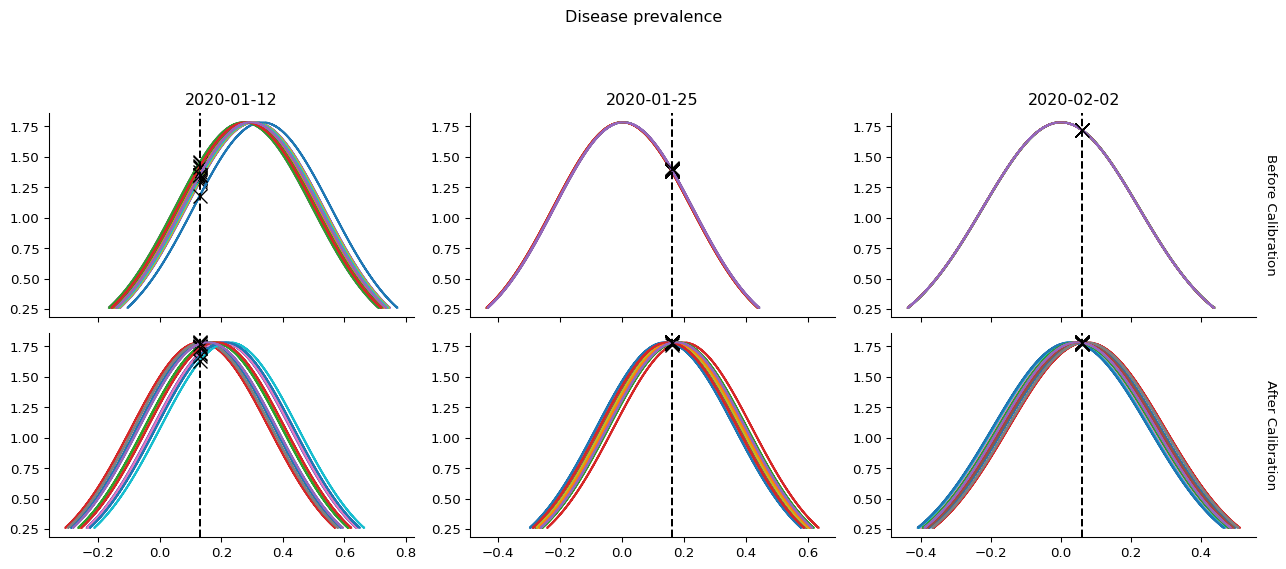

In [9]:
calib.plot();

Another way to plot the results is via bootstrapping. Here we repeatedly choose 15 from the `n_reps=15` simulations (with replacement), compute the average (or sum for some components), and repeatedly calculate the mean. We then plot the distribution of means, and hope it lands near the vertical dashed lines representing the real data.

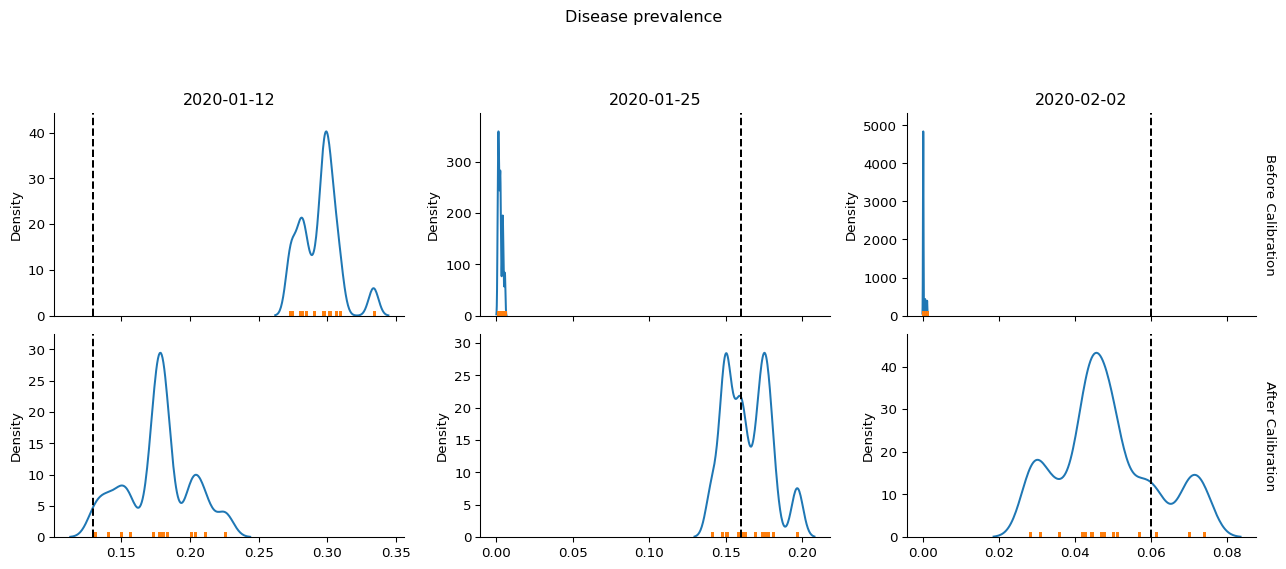

In [10]:
calib.plot(bootstrap=True); # Pass bootstrap=True to produce this plot

We can view some plots of the final fitted results. Whereas the two plots above were from the `check_fit`, running both "guess" and "best" parameters, here we make make new simulations to visualize the results.

Elapsed time: 1.29 s


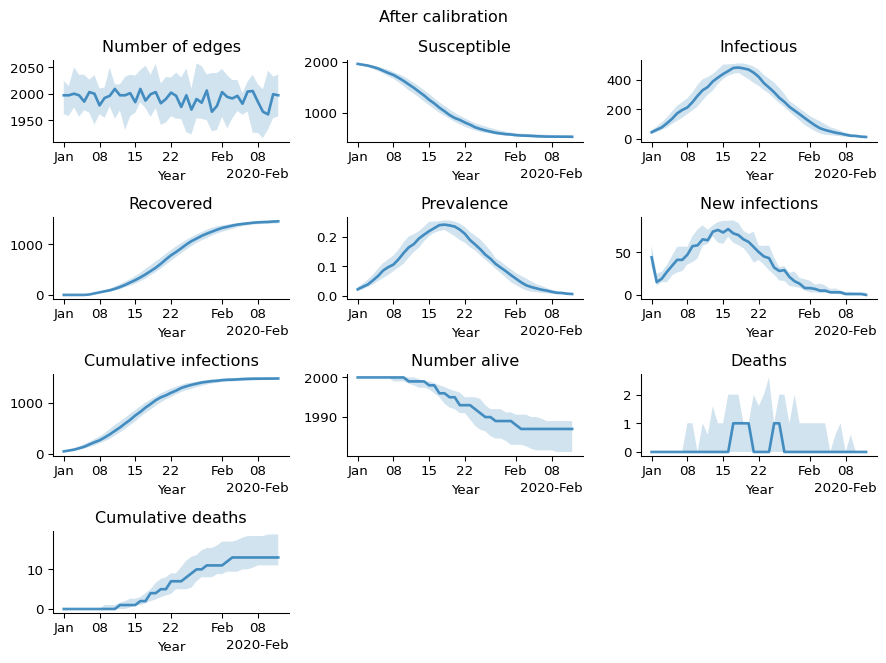

In [11]:
g = calib.plot_final(); # Run the model for build_kw['n_reps'] = 15 replicates
for ax in g.axes: # Fix the date formatting
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

Optuna has lots of diagnostic plots that we can explore. Possible plots include:
* plot_contour
* plot_edf
* plot_hypervolume_history
* plot_intermediate_values
* plot_optimization_history
* plot_parallel_coordinate
* plot_param_importances
* plot_pareto_front
* plot_rank
* plot_slice
* plot_terminator_improvement
* plot_timeline

Here are some examples:

/home/cliffk/idm/starsim/starsim/calibration.py:434: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = getattr(vis, method)(self.study)


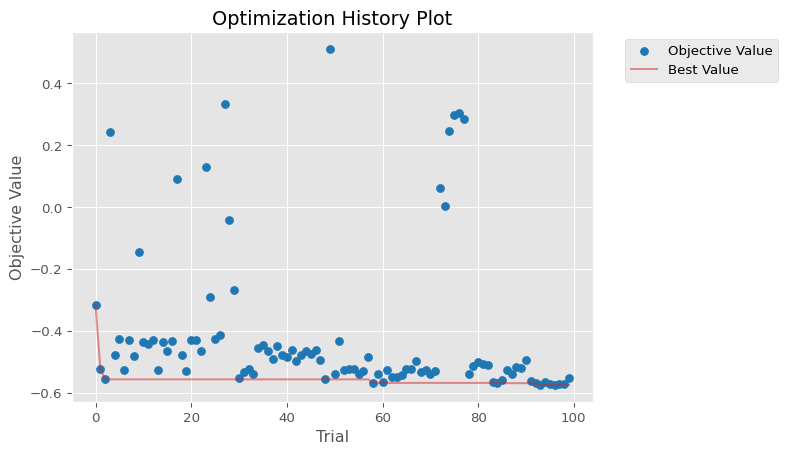

In [12]:
calib.plot_optuna('plot_optimization_history'); # Plot the optimization history

/home/cliffk/idm/starsim/starsim/calibration.py:434: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  fig = getattr(vis, method)(self.study)
[W 2025-03-06 03:10:18,340] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


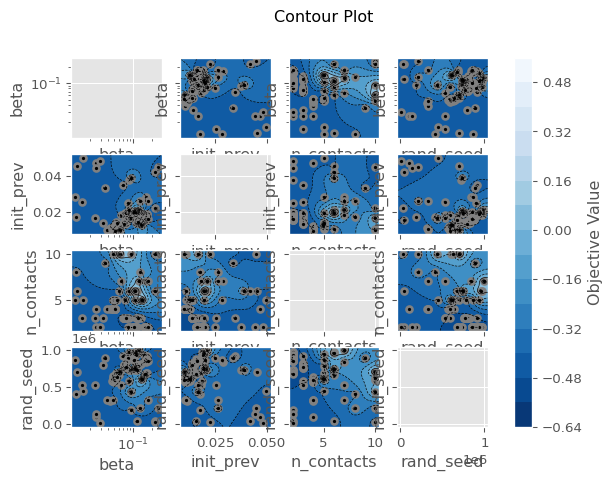

In [13]:
calib.plot_optuna('plot_contour');

In [14]:
calib.plot_optuna('plot_param_importances');

Could not run plot_param_importances: Tried to import 'sklearn' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'sklearn'.


/home/cliffk/idm/starsim/starsim/calibration.py:434: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = getattr(vis, method)(self.study)


If you choose not to use components, you can always create your own mismatch function, as in the following example:

In [15]:
my_data = (ss.date('2020-01-12'), 0.13)

def eval(sim, expected):
    # Compute the squared error at one point in time.
    # expected will contain my_data in this example due to eval_kw
    date, p = expected
    if not isinstance(sim, ss.MultiSim):
        sim = ss.MultiSim(sims=[sim])

    ret = 0
    for s in sim.sims:
        ind = np.searchsorted(s.results.timevec, date, side='left')
        prev = s.results.sir.prevalence[ind]
        ret += (prev - p)**2
    return ret


# Define the calibration parameters
calib_pars = dict(
    beta = dict(low=0.01, high=0.30, guess=0.15, suggest_type='suggest_float', log=True),
)

# Make the sim and data
sim = make_sim()

# Make the calibration
calib = ss.Calibration(
    calib_pars = calib_pars,
    sim = sim,
    build_fn = build_sim,
    build_kw = dict(n_reps=2), # Two reps per point
    reseed = True,
    eval_fn = eval, # Will call my_function(msim, eval_kwargs)
    eval_kw = dict(expected=my_data), # Will call eval(sim, **eval_kw)
    total_trials = 10,
    n_workers = None, # None indicates to use all available CPUs
    die = True,
    debug = debug,
)

# Perform the calibration
sc.printcyan('\nPeforming calibration...')
calib.calibrate()

# Check
calib.check_fit()


Peforming calibration...
Removed existing calibration file starsim_calibration.db
sqlite:///starsim_calibration.db


[I 2025-03-06 03:10:20,181] A new study created in RDB with name: starsim_calibration


Elapsed time: 0.227 s

Elapsed time: 0.255 s

[I 2025-03-06 03:10:20,818] Trial 1 finished with value: 0.4813799935157458 and parameters: {'beta': 0.192830829782566, 'rand_seed': 761680}. Best is trial 1 with value: 0.4813799935157458.


Elapsed time: 0.351 s

Elapsed time: 0.240 s

[I 2025-03-06 03:10:20,871] Trial 3 finished with value: 0.16073159486196326 and parameters: {'beta': 0.11161447485017412, 'rand_seed': 23645}. Best is trial 3 with value: 0.16073159486196326.


Elapsed time: 0.275 s

[I 2025-03-06 03:10:20,888] Trial 0 finished with value: 0.27049155004865044 and parameters: {'beta': 0.24296261343247827, 'rand_seed': 942265}. Best is trial 3 with value: 0.16073159486196326.


[I 2025-03-06 03:10:20,911] Trial 7 finished with value: 0.031378249999999996 and parameters: {'beta': 0.015471226237187401, 'rand_seed': 550423}. Best is trial 2 with value: 0.01662425.


[I 2025-03-06 03:10:20,911] Trial 2 finished with value: 0.01662425 and parameters: {'beta': 0.04443615479438011, 'rand_seed': 224268}. Best is trial 2 with value: 0.01662425.


Elapsed time: 0.267 s

Elapsed time: 0.310 s

[I 2025-03-06 03:10:20,951] Trial 8 finished with value: 0.1254562567595281 and parameters: {'beta': 0.282025806958211, 'rand_seed': 983201}. Best is trial 2 with value: 0.01662425.


[I 2025-03-06 03:10:20,970] Trial 10 finished with value: 0.2572845470684634 and parameters: {'beta': 0.12233440470475752, 'rand_seed': 176259}. Best is trial 2 with value: 0.01662425.


Elapsed time: 0.423 s

[I 2025-03-06 03:10:21,032] Trial 5 finished with value: 0.18615014260376922 and parameters: {'beta': 0.2631390554311254, 'rand_seed': 798228}. Best is trial 2 with value: 0.01662425.


Elapsed time: 0.329 s

[I 2025-03-06 03:10:21,059] Trial 13 finished with value: 0.02991125 and parameters: {'beta': 0.02194229083923002, 'rand_seed': 830688}. Best is trial 2 with value: 0.01662425.


Elapsed time: 0.356 s

Elapsed time: 0.286 s

[I 2025-03-06 03:10:21,089] Trial 14 finished with value: 0.005804721720540107 and parameters: {'beta': 0.07993245001393985, 'rand_seed': 827141}. Best is trial 14 with value: 0.005804721720540107.


[I 2025-03-06 03:10:21,090] Trial 11 finished with value: 0.03087925 and parameters: {'beta': 0.01856569583118919, 'rand_seed': 538058}. Best is trial 14 with value: 0.005804721720540107.


Elapsed time: 0.400 s

Elapsed time: 0.331 s

[I 2025-03-06 03:10:21,118] Trial 6 finished with value: 0.02662025 and parameters: {'beta': 0.0304917486123983, 'rand_seed': 340648}. Best is trial 14 with value: 0.005804721720540107.


Elapsed time: 0.256 s

[I 2025-03-06 03:10:21,127] Trial 4 finished with value: 0.2971709858392722 and parameters: {'beta': 0.23422123265745992, 'rand_seed': 260998}. Best is trial 14 with value: 0.005804721720540107.


Elapsed time: 0.413 s

[I 2025-03-06 03:10:21,140] Trial 18 finished with value: 0.02803225 and parameters: {'beta': 0.026574768284777058, 'rand_seed': 741977}. Best is trial 14 with value: 0.005804721720540107.


[I 2025-03-06 03:10:21,152] Trial 15 finished with value: 0.03162925 and parameters: {'beta': 0.01389196910190426, 'rand_seed': 218997}. Best is trial 14 with value: 0.005804721720540107.


Elapsed time: 0.257 s

Elapsed time: 0.433 s

[I 2025-03-06 03:10:21,187] Trial 19 finished with value: 0.02251925 and parameters: {'beta': 0.03676576975974425, 'rand_seed': 464777}. Best is trial 14 with value: 0.005804721720540107.


[I 2025-03-06 03:10:21,198] Trial 9 finished with value: 0.011585350904566836 and parameters: {'beta': 0.08438439423468984, 'rand_seed': 625145}. Best is trial 14 with value: 0.005804721720540107.


Elapsed time: 0.434 s

Elapsed time: 0.385 s

Elapsed time: 0.375 s

[I 2025-03-06 03:10:21,231] Trial 16 finished with value: 0.0024570257966026535 and parameters: {'beta': 0.07772537650267933, 'rand_seed': 669956}. Best is trial 16 with value: 0.0024570257966026535.


[I 2025-03-06 03:10:21,233] Trial 17 finished with value: 0.08316537803669219 and parameters: {'beta': 0.10060971530132325, 'rand_seed': 859716}. Best is trial 16 with value: 0.0024570257966026535.


[I 2025-03-06 03:10:21,233] Trial 12 finished with value: 0.439912363337194 and parameters: {'beta': 0.14565983770477994, 'rand_seed': 869656}. Best is trial 16 with value: 0.0024570257966026535.


Making results structure...
Processed 20 trials; 0 failed
Best pars: {'beta': 0.07772537650267933, 'rand_seed': 669956}
Removed existing calibration file starsim_calibration.db

Checking fit...


Elapsed time: 0.232 s
Fit with original pars: 0.45487601562584234
Fit with best-fit pars: 0.008768101538330747
✓ Calibration improved fit 0.45487601562584234 --> 0.008768101538330747


True

For more, take a look at `test_calibration.py` in the `tests` directory.